In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 1.zero_padding

In [4]:
def zero_pad(X, pad):
    """
    作用：给样本集X的所有样本进行零填充
    
    参数：
    X -- 样本集，维度是（m, n_H, n_W, n_c）
    pad -- padding的个数
    
    返回值：
    X_pad -- 返回填补后的样本集。维度是（m, n_H + 2*pad, n_W+ 2*pad, n_c）
    """
    
    #np.pad是numpy提供的一个零补函数
    X_pad = np.pad(X, ((0, 0),(pad, pad),(pad, pad),(0, 0)),'constant',constant_values = 0)
    
    return X_pad

In [5]:
#单元测试
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x, 2)
print('x.shape',x.shape)
print('x_pad.shape',x_pad.shape)
print('x[1,1] :',x[1,1])
print('x_pad[1,1]',x_pad[1,1])

x.shape (4, 3, 3, 2)
x_pad.shape (4, 7, 7, 2)
x[1,1] : [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


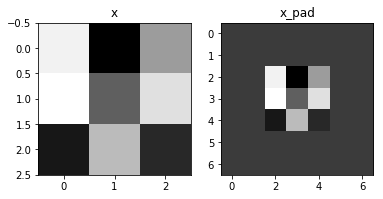

In [6]:
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[1].set_title('x_pad')
axarr[0].imshow(x[0,:,:,0])
axarr[1].imshow(x_pad[0,:,:,0])

## 2.单步卷积

In [9]:
def conv_single_step(a_slice_prev, W, b):
    """
    作用：只执行一步卷积
    
    参数：
    a_slice_prov -- 输入 矩阵中和过滤器卷积的那一块数据
                 -- 这里的输入矩阵也就是上一层的输出矩阵
    W -- 权重参数w。这里指的是过滤器，过滤器就是权重参数w
      -- 维度是（f, f, n_C_prev）,与a_slice_prev是一样的，因为是它俩进行卷积，所以维度是一样的
    b -- 阈值b，教程中我们说过每一个过滤器会有一个对应的阈值 维度是（1，1，1）
    
    返回值：
    Z -- 卷积一步后得到的一个数值，这个数值是一个输出矩阵的一个元素

    """
    #将a_slice_prev与W中的每一个元素进行相乘
    s = np.multiply(a_slice_prev, W) + b
    #将上面相乘的结果累加起来
    Z = np.sum(s)
    
    return Z

In [10]:
#单元测试
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print('Z:',Z)

Z: -23.16021220252078


## 3.前向传播

### 多个过滤器生成矩阵后构建多维矩阵

### 
<center>
    <video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
    </video>
</center>

### 获取子矩阵

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **图 3** </u><font color='purple'>  : **定位子矩阵** <br> </center></caption>

### 计算输出矩阵的维度

$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{这个是过滤器的个数}$$

In [19]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积网络的前向传播
    
    参数：
    A_prev -- 本层的输入矩阵，也就是上一层的输出矩阵。
           -- 维度是（m, n_H_prev, n_W_prev, n_C_prev）
    W -- 权重，也就是过滤器。维度是（f, f, n_C_prev, n_C），n_C表示过滤器的个数
    b -- 阈值，维度是（1，1，1，n_C）。一个过滤器一个阈值
    hparameters -- 数组参数步长stride数s和padding数p
    
    返回值：
    Z -- 输出矩阵，也就是卷积结果。维度是（m, n_H, n_W, n_C）
    cache -- 缓存一些数值， 以供反向传播时用
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride'] # 步长s
    pad = hparameters['pad'] # 填补数量p
    
    # 计算输出矩阵的维度。参考上面提供的公式    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1 # 使用int()来实现向下取整
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 初始化输出矩阵
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # 给输入矩阵进行padding填补0
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                 # 遍历每一个样本
        a_prev_pad = A_prev_pad[i]                     # 取出一个样本对应的输入矩阵
        for h in range(n_H):                           # 遍历输出矩阵的高
            for w in range(n_W):                       # 遍历输出矩阵的宽
                for c in range(n_C):                   # 遍历每一个过滤器
                    # 计算出输入矩阵中本次应该卷积的区域的索引，然后通过这些索引取出将被卷积的小块数据。
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # 利用之前我们实现的conv_single_step函数来对这块数据进行卷积。
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    assert(Z.shape == (m, n_H, n_W, n_C))
 
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [20]:
#单元测试
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {'pad' : 2,
               'stride' : 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean = ",np.mean(Z))
print("cache_conv[0][1][2][3] = ",cache_conv[0][1][2][3])

Z's mean =  0.15585932488906465
cache_conv[0][1][2][3] =  [-0.20075807  0.18656139  0.41005165]
